# This notebook contains the functions used to convert the disaggregated wind data from wind AD.ipynb to the appriate power curves for insertion into the HWP model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# import disaggregated data created in wind_AD.ipynb

df_wind = pd.read_csv('wind_disagg2.csv')
df_price = pd.read_csv('electricity_price_AD.csv')
df_power = pd.DataFrame()

In [1]:
def convert_wind_to_power(wind_speed):
    '''
    Converts wind data to raw power ouput of HWP wind farm
    
    Input:
    wind_speed: list of 8760 floats, disaggregated wind data
    
    Ouput:
    list of 8760 floats
    '''
    
    power_per_hour = []
    for i in wind_speed:
        if i >= 30 and i <= 250:
            MWh = (i/10)**3 #wind speeds are in dm/s. i/10 converts dm to m
            power_per_hour.append(round(MWh,3))
        else:
            MWh = 0
            power_per_hour.append(MWh)
    
    return power_per_hour

def calibrate_full_load_hours(wind_speed,full_load_hours,rated_power,threshold_percentage,iteration_maximum,c_provided=False):
    '''
    Converts raw power output to calibrated power ouput, using the 'full load hours' input from the ETM
    
    Input: 
    wind_speed: list of 8760 floats, disaggregated wind data
    full_load_hours: integer, amount of hours the windfarm generates maximum output in a year
    rated_power: rated power of simulated HWP wind farm (MW)
    threshold_percentage: float, desired calibration accuracy
    iteration_maximum: integer, maximum amount of iterations allowed to reach the desired calibration accuracy
    c_provided: boolean (True/False): internal switch to use for the creation of the imbalance power generation
                HWP input dataset that accompanies the calibrated power dataset
                
    Ouput:
    list of 8760 float values
    
    '''
    
    wind_to_power = convert_wind_to_power(wind_speed)
    
    FLH_production = rated_power * full_load_hours
    raw_production = sum([min(i,rated_power) for i in wind_to_power])
    
    c = FLH_production / raw_production
    if c_provided == False:
        #print('c not provided')
        attempts = 0
        while attempts < iteration_maximum:
            calibrated_production = [min(i * c, rated_power) for i in wind_to_power]
            remaining_diff = FLH_production / sum(calibrated_production)
        
            if abs(remaining_diff - 1)*100 > threshold_percentage:
                c *= remaining_diff
                attempts += 1
        
            else:
                print('attempts = {}, remaining discrepancy factor = {}'.format(attempts, FLH_production / sum(calibrated_production)))
            
                return calibrated_production,c
        
        print('iteration failed after {} attempts'.format(attempts))
    
    else: #c needs to be provided for wind lists with error to preserve the error
        #print('c is provided')
        calibrated_production = [min(i * c_provided, rated_power) for i in wind_to_power]
        return calibrated_production,c
    
def wind_error_day_ahead(wind_speed):
    '''
    adds uniform deviation to wind speed data, as described in the HWP model report
    
    Input:
    wind_speed: list of 8760 floats, disaggregated wind data
    
    Ouput:
    list of 8760 float values
    
    '''
    wind_with_error = [i + random.uniform(-3, 3) for i in wind_speed]
    
    return wind_with_error

def generate_HWP_input(df,disagg_type):
    '''
    Generates, based on disaggregated wind data, the four needed input datasets for the HWP model
    
    Input:
    df: Dataframe column (8760 floats), disaggregated wind data
    disagg_type: string, specifies which disaggregation method is used
    
    Ouput:
    Dataframe with four columns to be inserted into HWP:
    - power output per hour
    - power output with error per hour
    - maximum allowed purchase of imbalance power per hour
    - maximum allowed selling of imbalance power per hour
    '''
    
    #w error is the actual power produced in the HWP
    calibrated_values = calibrate_full_load_hours(df_wind['{}'.format(disagg_type)],3000,5633,0.00000001,100)
    
    df['{}'.format(disagg_type)] = calibrated_values[0]
    df['{}_w_error'.format(disagg_type)] = calibrate_full_load_hours(wind_error_day_ahead(df_wind['{}'.format(disagg_type)]),3000,5633,0.00000001,\
                                                        100,c_provided=calibrated_values[1])[0]
    df['{}_buy_imb'.format(disagg_type)] = df.apply(lambda x: max(x['{}'.format(disagg_type)] - \
                                                                              x['{}_w_error'.format(disagg_type)],0), axis=1)
    df['{}_sell_imb'.format(disagg_type)] = df.apply(lambda x: -min(x['{}'.format(disagg_type)] - \
                                                                               x['{}_w_error'.format(disagg_type)],0), axis=1)



In [4]:
# generate HWP input dataset for each disaggregation technique

generate_HWP_input(df_power,'rolling_average')
generate_HWP_input(df_power,'triangular')
generate_HWP_input(df_power,'weibull')
generate_HWP_input(df_power,'baseline')

attempts = 18, remaining discrepancy factor = 1.0000000000736344
attempts = 19, remaining discrepancy factor = 1.00000000006443
attempts = 15, remaining discrepancy factor = 1.0000000000277063
attempts = 19, remaining discrepancy factor = 1.0000000000360398


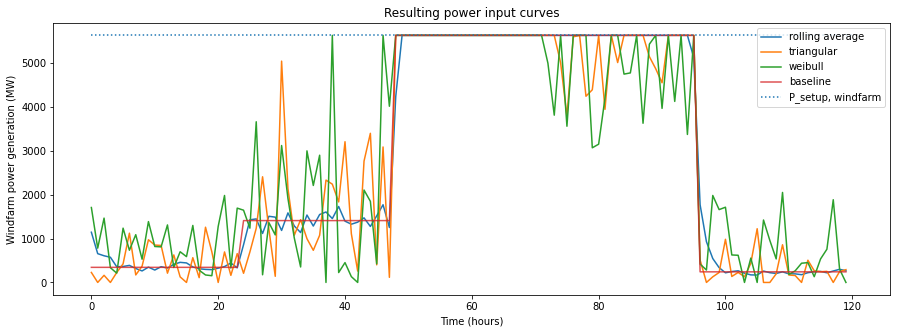

In [16]:
# plot resulting power input curves for verification

plt.figure(figsize=(15, 5))
plot_length = 120
x = [i for i in range(plot_length)]
plt.plot(x,df_power['rolling_average'][120:120+plot_length],label= 'rolling average')
plt.plot(x,df_power['triangular'][120:120+plot_length],label = 'triangular')
plt.plot(x,df_power['weibull'][120:120+plot_length],label = 'weibull')
plt.plot(x,df_power['baseline'][120:120+plot_length],label = 'baseline',alpha=0.8)
plt.hlines(y = 5633, xmin = 0, xmax = plot_length,label='P_setup, windfarm', linestyle=':')
plt.title('Resulting power input curves')
plt.ylabel('Windfarm power generation (MW)')
plt.xlabel('Time (hours)')
plt.legend(loc='upper right')


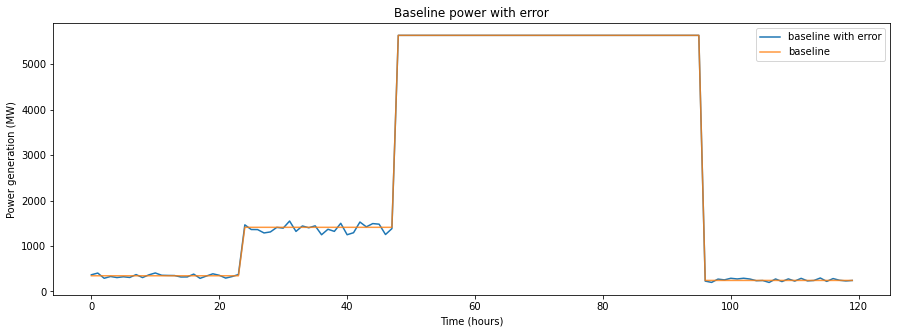

In [10]:
# plot power generation error (baseline) for verification

plt.figure(figsize=(15, 5))
plot_length = 120
x = [i for i in range(plot_length)]
plt.plot(x,df_power['baseline_w_error'][120:120+plot_length],label= 'baseline with error')

plt.plot(x,df_power['baseline'][120:120+plot_length],label = 'baseline',alpha=0.8)
plt.title('Baseline power with error')
plt.ylabel('Power generation (MW)')
plt.xlabel('Time (hours)')
plt.legend()

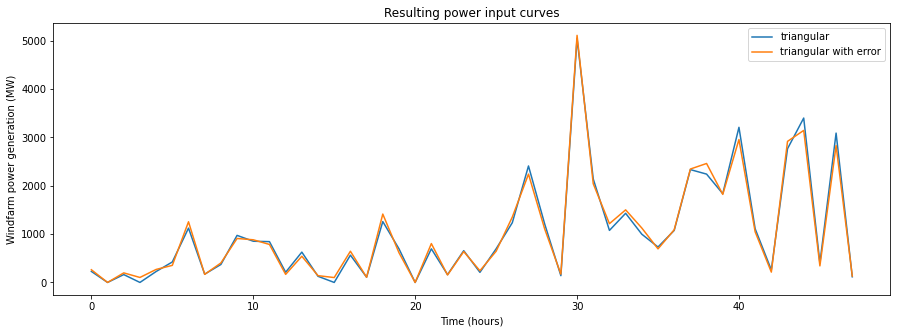

In [8]:
# plot power generation error (triangular) for verification

plt.figure(figsize=(15, 5))
plot_length = 48
x = [i for i in range(plot_length)]
plt.plot(x,df_power['triangular'][120:120+plot_length],label = 'triangular')
plt.plot(x,df_power['triangular_w_error'][120:120+plot_length],label = 'triangular with error')
plt.title('Resulting power input curves')
plt.ylabel('Windfarm power generation (MW)')
plt.xlabel('Time (hours)')
plt.legend()

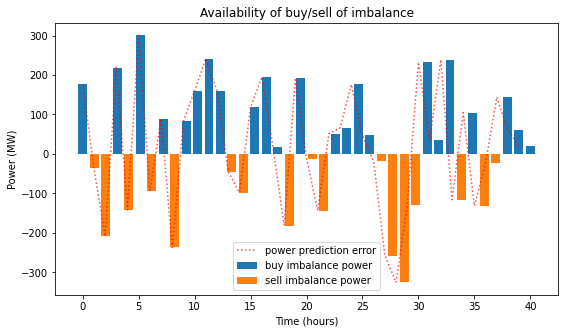

In [7]:
# plot availability to buy/sell imbalance power for verification

plt.figure(figsize=(9, 5))

buy = df_power.apply(lambda x: max(x['triangular'] - x['triangular_w_error'],0), axis=1)
sell = df_power.apply(lambda x: min(x['triangular'] - x['triangular_w_error'],0), axis=1)

x = np.linspace(0,40,40)
plt.bar(x,buy[:40],label = 'buy imbalance power')
plt.bar(x,sell[:40],label = 'sell imbalance power')
plt.plot(df_power['triangular'][:40] - df_power['triangular_w_error'][:40],color='red' \
         ,alpha=0.7,linestyle=':',label='power prediction error')

plt.title('Availability of buy/sell of imbalance')
plt.ylabel('Power (MW)')
plt.xlabel('Time (hours)')
plt.legend()
plt.show()

In [9]:
# output HWP input data to csv for manual insertion into HWP

#df_power.to_csv('Final_input_HWP.csv',index=False,sep=';',decimal='.')